In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [2]:
data_path = "./data/old_data/GEARBOX_processed.csv"
df = pd.read_csv(data_path)
df.head()

,Turbine_ID,Timestamp,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Min_Windspeed1,Max_Windspeed1,Avg_Windspeed1,Var_Windspeed1,Min_Windspeed2,Max_Windspeed2,...,Anemometer2_CorrOffset,DistanceAirPress,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq,Label,Next_Default_Date,Lead_Time,Default_in_60
0,T01,2016-01-01 00:00:00+00:00,44,48,3.7,6.0,5.1,0.21,3.8,6.0,...,0.0,0.0,600.0,98.0,99.0,418.0,0.0,2016-07-18 02:10:00+00:00,199,False
1,T01,2016-01-01 00:10:00+00:00,44,48,4.1,6.0,5.1,0.09,4.1,6.0,...,0.0,0.0,600.0,99.0,101.0,418.0,0.0,2016-07-18 02:10:00+00:00,199,False
2,T01,2016-01-01 00:20:00+00:00,43,46,4.5,6.7,5.7,0.26,4.4,6.8,...,0.0,0.0,600.0,111.0,113.0,418.0,0.0,2016-07-18 02:10:00+00:00,199,False
3,T01,2016-01-01 00:30:00+00:00,44,48,5.1,7.0,6.3,0.11,5.1,7.1,...,0.0,0.0,600.0,122.0,125.0,418.0,0.0,2016-07-18 02:10:00+00:00,199,False
4,T01,2016-01-01 00:40:00+00:00,44,48,4.7,7.3,6.2,0.27,4.9,7.4,...,0.0,0.0,600.0,121.0,123.0,417.0,0.0,2016-07-18 02:10:00+00:00,199,False


In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Next_Default_Date'] = pd.to_datetime(df['Next_Default_Date'])
df['Label_SVM'] = df['Default_in_60'].astype(int)

df.sort_values('Timestamp', inplace=True)
window_size = 24*6
df_features = df.drop(['Timestamp', 'Next_Default_Date', 'Label', 'Default_in_60', 'Lead_Time', 'Label_SVM'], axis=1)

df_movin_mean = df_features.groupby('Turbine_ID').apply(lambda x: x.rolling(window=window_size, min_periods=1).mean())
df_movin_mean.columns = [x+'_avg' for x in df_movin_mean.columns]
df_movin_std = df_features.groupby('Turbine_ID').apply(lambda x: x.rolling(window=window_size, min_periods=1).std()).fillna(1)
df_movin_std.columns = [x+'_std' for x in df_movin_std.columns]
df = pd.concat([df, df_movin_mean, df_movin_std], axis=1)
df.head()

,Turbine_ID,Timestamp,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Min_Windspeed1,Max_Windspeed1,Avg_Windspeed1,Var_Windspeed1,Min_Windspeed2,Max_Windspeed2,...,Anemometer1_CorrOffset_std,Anemometer2_Freq_std,Anemometer2_Offset_std,Anemometer2_CorrGain_std,Anemometer2_CorrOffset_std,DistanceAirPress_std,AirRessureSensorZeroOffset_std,Anemometer1_Avg_Freq_std,Anemometer2_Avg_Freq_std,Pressure_Avg_Freq_std
0,T01,2016-01-01 00:00:00+00:00,44,48,3.7,6.0,5.1,0.21,3.8,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
172522,T07,2016-01-01 00:00:00+00:00,45,49,3.7,6.0,5.1,0.21,3.8,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
346873,T11,2016-01-01 00:00:00+00:00,48,55,3.7,6.0,5.1,0.21,3.8,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
87140,T06,2016-01-01 00:00:00+00:00,43,48,3.7,6.0,5.1,0.21,3.8,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
259723,T09,2016-01-01 00:00:00+00:00,43,48,3.7,6.0,5.1,0.21,3.8,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
test_size = 0.25
val_size = 0.15

df1 = df.sort_values(by='Timestamp')
df1.reset_index(drop=True, inplace=True)
first_label_1_index = df1[df1['Label'] == 1].index[0]
len_df1 = len(df1)
start_index = max(0, first_label_1_index - int(0.23 * len_df1))
end_index = start_index + int(test_size * len_df1)

test_data = df1.iloc[start_index:end_index].reset_index(drop=True)
train_data = pd.concat([df1.iloc[:start_index], df1.iloc[end_index:]]).reset_index(drop=True)
assert (len(df1) - (len(test_data) + len(train_data))==0)
assert(len(test_data.Label.value_counts()) > 1 and len(train_data.Label.value_counts())>1)
len(test_data), len(train_data)

(108528, 325587)

In [5]:
drop_ls = ['Turbine_ID', 'Timestamp', 'Next_Default_Date', 'Label', 'Default_in_60', 'Label_SVM', 'Lead_Time']

def balance_data(df):
    df_majority = df[df.Label_SVM == 0].copy()
    df_minority = df[df.Label_SVM == 1].copy()

    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    
                                    n_samples=len(df_minority),    
                                    random_state=123)

    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    X_balanced = df_balanced.drop(drop_ls, axis=1).copy()
    y_balanced = df_balanced['Label_SVM'].copy()
    return X_balanced, y_balanced

X_balanced, y_balanced = balance_data(train_data)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=val_size, random_state=42)

test_set = test_data.drop(drop_ls, axis=1).copy()
Y_event = test_data.apply(lambda x: x['Turbine_ID'] + ' ' + str(x['Next_Default_Date']), axis=1).tolist()
Y_lead = test_data['Lead_Time'].tolist()

In [6]:
def evaluate_y_pred(y_true, y_pred, Y_event, Y_lead):
    assert len(y_true) / len(y_pred) * len(Y_event) / len(Y_lead) == 1
        
    FP, FN, TP_lead = 0, 0, []
    warnings = {}
    for i in range(len(y_pred)):
        if y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_true[i] == 1:
            event = Y_event[i]
            lead_time = Y_lead[i]
            if event not in warnings and y_pred[i] == 0:
                warnings[event] = -1
            elif event not in warnings and y_pred[i] == 1:
                warnings[event] = lead_time
            elif event in warnings and warnings[event] < 0:
                if y_pred[i] == 1:
                    warnings[event] = lead_time
    for event, lead in warnings.items():
        if lead < 0:
            FN += 1
        else:
            TP_lead.append(lead)

    R, M, I = 100000, 20000, 5000
    savings = 0
    for l in TP_lead:
        savings += (l / 60) * (R - M)
    savings -= FP * I
    savings -= FN * R
    print(warnings.keys())
    return FP, FN, TP_lead, savings

# SVM

In [7]:
def find_latest_consecutive_trues(arr, consec=2):
    latest_true_positions = []
    current_sequence_start = None
    current_sequence_length = 0

    for i, value in enumerate(arr):
        if value:
            current_sequence_length += 1
            if current_sequence_start is None:
                current_sequence_start = i
            if i == len(arr) - 1 and current_sequence_length >= consec:
                latest_true_positions.append(i)
        else:
            if current_sequence_start is not None and current_sequence_length >= consec:
                # We've hit the end of a sequence of Trues with more than one True, record the last position
                latest_true_positions.append(i-1)
            # Reset for the next sequence
            current_sequence_start = None
            current_sequence_length = 0

    return latest_true_positions

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report

model = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, class_weight={0: 5, 1: 1}, max_iter=5000000))

model.fit(X_train_balanced, y_train_balanced)
print('Training complete')
y_pred = model.predict(X_test_balanced)
conf_matrix = confusion_matrix(y_test_balanced, y_pred)
class_report = classification_report(y_test_balanced, y_pred)

print(conf_matrix)
print(class_report)

Training complete
[[1266   52]
 [ 110 1146]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1318
           1       0.96      0.91      0.93      1256

    accuracy                           0.94      2574
   macro avg       0.94      0.94      0.94      2574
weighted avg       0.94      0.94      0.94      2574



In [9]:
total_savings = 0
warn_issue = {}
for t in ['T01','T06','T07','T09','T11']:
    test_sub = df1[df1['Turbine_ID'] == t]
    X_test = test_sub.drop(drop_ls, axis=1).copy()
    Y_test = test_sub['Label_SVM']
    Y_lead = test_sub['Lead_Time'].tolist()
    Y_time = test_sub['Timestamp'].tolist()
    Y_default = test_sub.apply(lambda x: x['Turbine_ID'] + ' ' + str(x['Next_Default_Date']), 
                                axis=1).tolist()
    print(X_test.shape)
    y_pred = model.predict(X_test)
    y_pred_new = np.zeros(len(y_pred))
    idx = find_latest_consecutive_trues(y_pred, 6*7)
    for j in idx:
        y_pred_new[j] = 1
    
    last_warn_time = None
    for i in range(len(y_pred_new)):
        if y_pred_new[i] == 1 and last_warn_time is None:
            last_warn_time = Y_time[i]
        elif y_pred_new[i] == 1 and last_warn_time is not None:
            warn_time = Y_time[i]
            if (warn_time - last_warn_time) / np.timedelta64(1, 'D') < 7:
                y_pred_new[i] = 0
            else:
                last_warn_time = warn_time
    
    y_true = Y_test.astype(int)
    warn_issue[t] = {
        "y_true": y_true,
        "y_pred": y_pred_new,
        "t": test_sub.iloc[:, 1].to_numpy()
    }
    FP, FN, TP_lead, savings = evaluate_y_pred(y_true.tolist(), 
                                               y_pred_new, 
                                               Y_default, 
                                               Y_lead)
    print(FP, FN, TP_lead, savings)
    total_savings += savings
print(f"Total Savings: {total_savings}")

(87140, 126)
dict_keys(['T01 2016-07-18 02:10:00+00:00'])
8 0 [54] 32000.0
(85382, 126)
dict_keys([])
10 0 [] -50000
(87201, 126)
dict_keys([])
8 0 [] -40000
(87150, 126)
dict_keys(['T09 2016-10-11 08:10:00+00:00'])
19 0 [60] -15000.0
(87242, 126)
dict_keys([])
12 0 [] -60000
Total Savings: -133000.0


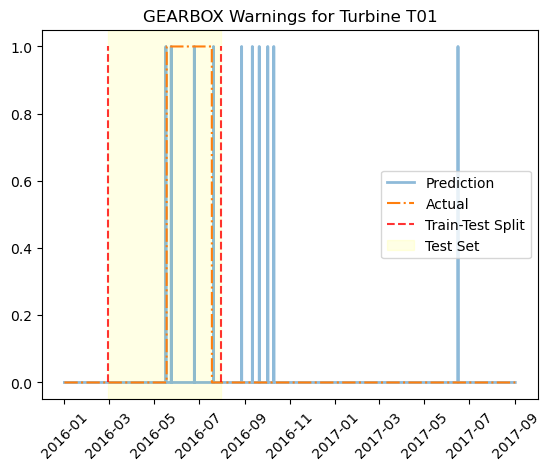

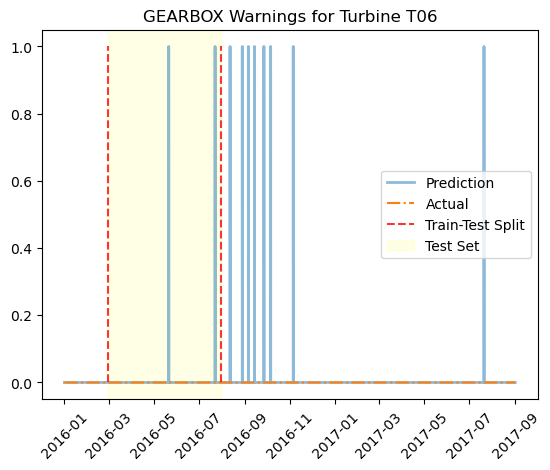

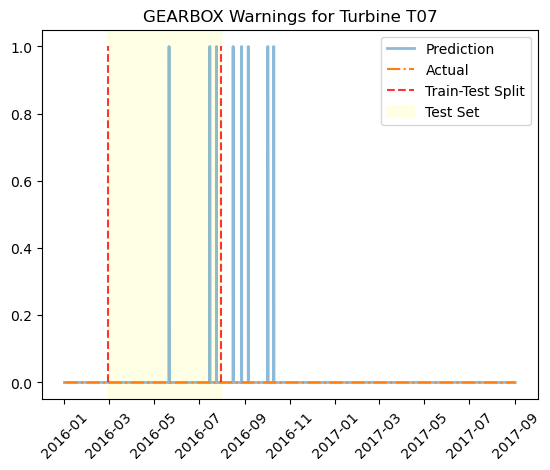

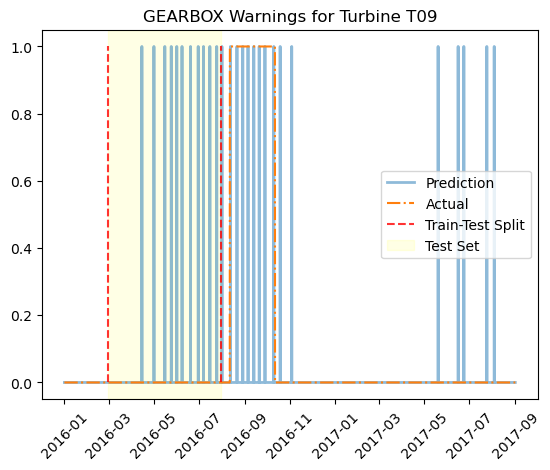

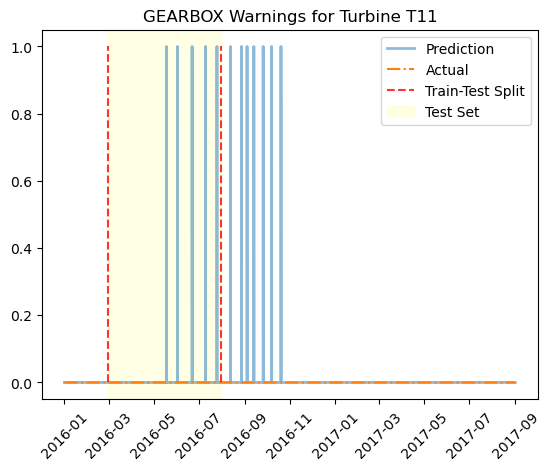

In [10]:
import matplotlib.pyplot as plt
st1 = test_data['Timestamp'].iloc[1]
st2 = test_data['Timestamp'].iloc[-1]
for turbine, y_dict in warn_issue.items():
    y_true = pd.DataFrame({
        "t": y_dict["t"],
        "y_true": y_dict["y_true"]
    }).set_index("t")
    
    y_pred = pd.DataFrame({
        "t": y_dict["t"],
        "y_pred": y_dict["y_pred"].reshape(-1)
    }).set_index("t")

    plt.plot(y_pred, linewidth=2, alpha=0.5, label="Prediction")
    plt.plot(y_true, ls="-.", alpha=1, label="Actual")
    plt.vlines(x=st1, ymin=0, ymax=1, alpha=0.8, ls="--", color="red", label="Train-Test Split")
    plt.vlines(x=st2, ymin=0, ymax=1, alpha=0.8, ls="--", color="red")
    plt.axvspan(st1, st2, color='yellow', alpha=0.1, label='Test Set')
    # plt.axvspan(train_data['Timestamp'].iloc[1], st1, color='green', alpha=0.05, label='Train Set')
    # plt.axvspan(st2, train_data['Timestamp'].iloc[-1], color='green', alpha=0.05)
    plt.title(f"GEARBOX Warnings for Turbine {turbine}")
    plt.legend(loc="best")
    plt.xticks(rotation=45)
    plt.show()